In [1]:
from os.path import join

import numpy as np
from numpy.linalg import svd, norm
from scipy.io import loadmat

import matplotlib.pyplot as plt

In [2]:
def loadfaces(path):
    """Load Yale B faces database"""
    contents = loadmat(path)
    faces = contents['faces']
    m, n = [int(contents[k]) for k in ['m', 'n']]
    nfaces = contents['nfaces'][0]
    return faces, m, n, nfaces


def RPCA(X):
    """
    Robust PCA
    
    Decompose a data matrix X into a structured low-rank matrix L and a sparse matrix S
    containing outliers and corrupt data.
    """
    def shrink(X, τ):
        """Shrinkage operator"""
        return np.sign(X) * np.maximum(abs(X) - τ, 0)

    def SVT(X, τ):
        """Singular value threshold operator"""
        U, S, VT = svd(X, full_matrices=False)
        return U @ np.diag(shrink(S, τ)) @ VT

    nrows, ncols = X.shape
    μ = nrows * ncols / (4 * abs(X).sum())
    λ = 1 / np.sqrt(max(nrows, ncols))
    threshold = 1e-7 * norm(X)
    
    S = np.zeros_like(X)
    Y = np.zeros_like(X)
    L = np.zeros_like(X)
    for count in range(1000):
        if norm(X - L - S) <= threshold:
            break
        L = SVT(X - S + (1/μ) * Y, τ=1/μ)
        S = shrink(X - L + (1/μ) * Y, τ=λ/μ)
        Y += μ * (X - L - S)
    return L, S

In [3]:
faces, m, n, nfaces = loadfaces(join('..', 'DATA', 'allFaces.mat'))
X = faces[:, :nfaces[0]].astype(float)

In [4]:
L, S = RPCA(X)

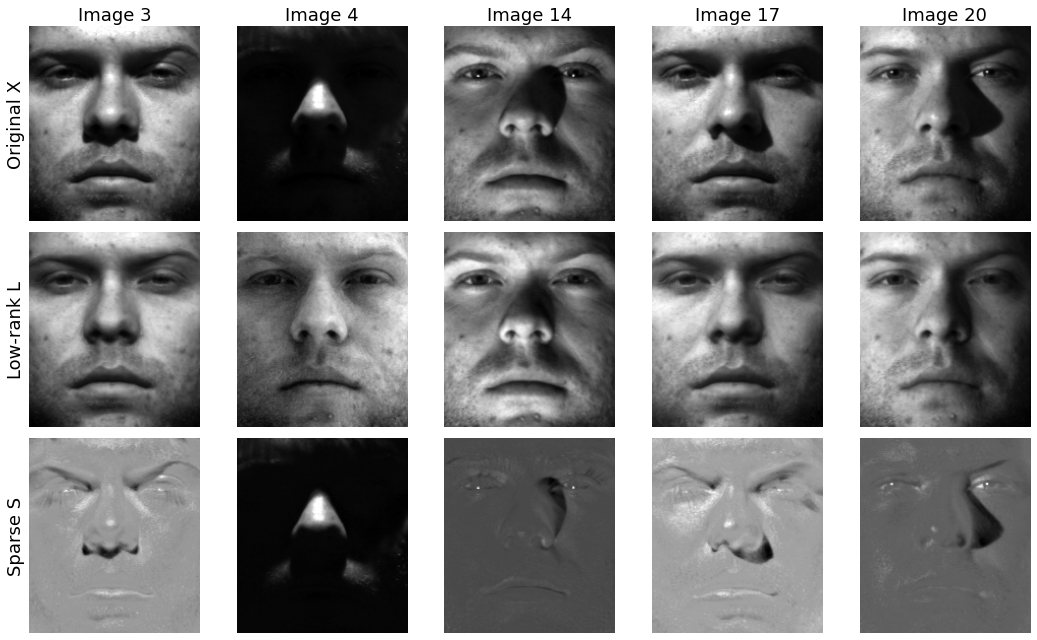

In [5]:
indices = [2, 3, 13, 16, 19]
fig, axs = plt.subplots(3, len(indices), figsize=(len(indices)*3, 3*3), sharex=True, sharey=True)
for i, k in enumerate(indices):
    for ax, im in zip(axs[:, i], [X, L, S]):
        ax.imshow(im[:, k].reshape((m, n)).T, cmap='gray')

        # Get rid of axis ticks, labels and spines but leave labels
        ax.set_xticks([]) 
        ax.set_yticks([])
        ax.set_xticklabels([]) 
        ax.set_yticklabels([])
        for spine in ax.spines.values():
            spine.set_visible(False)

for ax, label in zip(axs[:, 0], ['Original X', 'Low-rank L', 'Sparse S']):
    ax.set_ylabel(label, fontsize=18)
for ax, title in zip(axs[0, :], [f'Image {i+1}' for i in indices]):
    ax.set_title(title, fontsize=18)
    
plt.tight_layout()